# Notebook to plot results from inpainting

## Setup

In [1]:
# imports
import csv
from collections import defaultdict
from dataclasses import dataclass, field
import numpy as np
from pathlib import Path
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


In [2]:
# dataclass for a single plotted point (corresponding to one split)
@dataclass
class InpaintPoint:
    subtype: str # subtype folder name
    train_pool: int # number of samples in training pool
    mean_psnr: float # mean PSNR over test set
    fold_id: int # fold index parsed from cvfoldX
    tag: str # model tag parsed from checkpoint filename
    csv_path: Path # path to metrics_test.csv file with detailed results


In [3]:
# dataclass for scanning and plotting
@dataclass
class InpaintPlotConfig:

    # data
    PRETRAIN_ROOT: str = '/ministorage/adina/selma_inpaint_preds_autumn_sweep_27/preds' # root dir with pretrained preds
    RANDOM_ROOT: str = '/ministorage/adina/selma_inpaint_preds_rand_ntc/preds' # root dir with random preds
    SUBTYPES: list = field(default_factory=lambda: ['ALL']) # list of subtype folder names to include; ALL for all
    EXCLUDE_SUBTYPES: list = field(default_factory=list) # list of subtype folder names to exclude; [] for none
    OUTPUT_DIR: str = None # output dir for plots; None to skip saving
    ASCENDING: bool = True # whether to plot train pool size in ascending order
    PLOT_COMBINED: bool = False # whether to plot combined subtypes in addition to individual subtypes

    # pretrained series styling
    PRETRAIN_POINT_COLOR: str = 'cornflowerblue'
    PRETRAIN_LINE_COLOR: str = 'cornflowerblue'
    PRETRAIN_MARKER: str = 'o'
    PRETRAIN_LINESTYLE: str = '-'
    PRETRAIN_LABEL: str = 'Pretrained'

    # random series styling
    RANDOM_POINT_COLOR: str = 'lightcoral'
    RANDOM_LINE_COLOR: str = 'lightcoral'
    RANDOM_MARKER: str = 'x'
    RANDOM_LINESTYLE: str = '--'
    RANDOM_LABEL: str = 'Random init'

    # opacities and line configs
    PRETRAIN_LINE_ALPHA: float = 0.7
    RANDOM_LINE_ALPHA: float = 0.7
    PRETRAIN_POINT_ALPHA: float = 0.8
    RANDOM_POINT_ALPHA: float = 0.8
    PRETRAIN_FIT_LINE: bool = True # whether to plot pretrained fit line
    RANDOM_FIT_LINE: bool = True # whether to plot random init fit line


## Functions

In [4]:
# function to find subtypes
def _find_subtypes(root, requested, exclude=None):

    # handle ALL case
    if any(s.upper() == 'ALL' for s in requested):
        subtypes = sorted([d.name for d in root.iterdir() if d.is_dir()])

        # apply exclusions
        if exclude:
            subtypes = [s for s in subtypes if s not in set(exclude)]

        # return found subtypes
        return subtypes
    return requested


In [5]:
# function to parse fold and train pool from path
def _parse_fold_and_pool(tag):

    # define regex patterns
    RE_CVFOLD = re.compile(r'cvfold(\d+)')
    RE_TRLIM = re.compile(r'_trlim(\d+|ALL)')
    RE_FTTR = re.compile(r'_fttr(\d+)')
    RE_FTVAL = re.compile(r'_ftval(\d+)')

    # parse fold
    fold_match = RE_CVFOLD.search(tag)
    fold_id = int(fold_match.group(1)) if fold_match else -1

    # parse train pool size
    ntr_match = None
    ntr_match = RE_TRLIM.search(tag)
    if ntr_match:
        val = ntr_match.group(1)
        if val != 'ALL':
            try:
                ntr_match = int(val)
            except Exception:
                ntr_match = None

    # if not ntr_match found, try to sum fttr and ftval
    if ntr_match is None:
        ntr_match1 = RE_FTTR.search(tag)
        ntr_match2 = RE_FTVAL.search(tag)
        if ntr_match1 and ntr_match2:
            try:
                ntr_match = int(ntr_match1.group(1)) + int(ntr_match2.group(1))
            except Exception:
                ntr_match = None

    return fold_id, ntr_match


In [6]:
# function to read mean psnr from metrics csv
def _read_mean_psnr(csv_path):

    # list of values
    psnr_vals = []

    # read csv
    try:
        with open(csv_path, 'r', newline='') as f:
            for row in csv.DictReader(f):
                x = row.get('psnr_masked', '')
                try:
                    psnr_vals.append(float(x))
                except Exception:
                    pass
    except FileNotFoundError:
        return None
    
    if not psnr_vals:
        return None
    
    # return mean
    return float(np.nanmean(psnr_vals))


In [7]:
# function to collect points for a subtype
def _collect_points_for_subtype(subtype, preds_root):

    # list of points
    points = []

    # get subtype dir
    subdir = preds_root / subtype
    if not subdir.exists():
        print(f'[WARN] Missing subtype dir: {subdir}', flush=True)
        return points
    
    # iterate over cvfold dirs
    tag_dirs = sorted([d for d in subdir.iterdir() if d.is_dir()])
    found = 0

    for tag_dir in tag_dirs:

        # get tag from dir name
        tag = tag_dir.name

        # get path to metrics csv
        mpath = tag_dir / 'preds' / 'metrics_test.csv'
        if not mpath.exists():
            continue
        found += 1

        # parse fold and train pool
        fold_id, pool = _parse_fold_and_pool(tag)
        if pool is None:
            print(f'[WARN] Could not parse train pool size from tag: {tag}', flush=True)
            continue

        # read mean psnr
        mean_psnr = _read_mean_psnr(mpath)
        if mean_psnr is None or np.isnan(mean_psnr):
            print(f'[WARN] Could not read mean PSNR from csv: {mpath}. Skipping.', flush=True)
            continue
        
        # create point and add to list
        points.append(InpaintPoint(subtype=subtype, train_pool=pool, mean_psnr=mean_psnr,
                                  fold_id=fold_id, tag=tag, csv_path=mpath))
        
    print(f'[INFO] {subtype}: scanned {len(tag_dirs)} tags, found {found} metrics csvs, kept {len(points)} points.', flush=True)
    return points


In [8]:
# function to calculate bets fit line
def _calculate_best_fit_line(x_vals, y_vals):
    if len(x_vals) < 2:
        return None
    x_min, x_max = min(x_vals), max(x_vals)
    xfit = np.linspace(x_min, x_max, 100)
    coeffs = np.polyfit(x_vals, y_vals, deg=1)
    yfit = np.polyval(coeffs, xfit)
    return xfit, yfit


In [9]:
# plotting function
def plot_subtype_inpaint(subtype, pretrain_points, random_points, cfg):

    # ensure there are points to plot
    if not pretrain_points and not random_points:
        print(f'[WARN] No points to plot for subtype {subtype}. Skipping.', flush=True)
        return None
    
    # get pretrain points by fold as dict
    pretrain_by_fold = defaultdict(list)
    for pt in pretrain_points:
        pretrain_by_fold[pt.fold_id].append(pt)

    # create figure
    plt.figure(figsize=(8,6))

    # plot pretrained points
    first_pretrain = True
    h_pretrain_points = h_pretrain_fit = h_rand_points = h_rand_fit = None

    for fold_id in sorted(pretrain_by_fold.keys()):
        pts = sorted(pretrain_by_fold[fold_id], key=lambda p: p.train_pool, reverse=not cfg.ASCENDING)
        x_vals = [p.train_pool for p in pts]
        y_vals = [p.mean_psnr for p in pts]
        lbl = cfg.PRETRAIN_LABEL if first_pretrain else '_nolegend_'
        h = plt.scatter(x_vals, y_vals, label=lbl, color=cfg.PRETRAIN_POINT_COLOR, 
                        marker=cfg.PRETRAIN_MARKER, alpha=cfg.PRETRAIN_POINT_ALPHA, zorder=3)
        if first_pretrain:
            h_pretrain_points = h
            first_pretrain = False

    # plot random init points
    random_x_vals, random_y_vals = [], []
    if random_points:
        rpts = sorted(random_points, key=lambda p: p.train_pool, reverse=not cfg.ASCENDING)
        random_x_vals = [p.train_pool for p in rpts]
        random_y_vals = [p.mean_psnr for p in rpts]
        h_rand = plt.scatter(random_x_vals, random_y_vals, label=cfg.RANDOM_LABEL, color=cfg.RANDOM_POINT_COLOR,
                             marker=cfg.RANDOM_MARKER, alpha=cfg.RANDOM_POINT_ALPHA, zorder=3)
        h_rand_points = h_rand

    # plot pretrained fit line
    if cfg.PRETRAIN_FIT_LINE and pretrain_points:
        xs_all = [p.train_pool for p in pretrain_points]
        ys_all = [p.mean_psnr for p in pretrain_points]
        fit = _calculate_best_fit_line(xs_all, ys_all)
        if fit:
            xfit, yfit = fit
            h_pretrain_fit = plt.plot(xfit, yfit, label=f'{cfg.PRETRAIN_LABEL} best fit', color=cfg.PRETRAIN_LINE_COLOR, linestyle=cfg.PRETRAIN_LINESTYLE,
                                     alpha=cfg.PRETRAIN_LINE_ALPHA, zorder=2)[0]
            
    # plot random init fit line
    if cfg.RANDOM_FIT_LINE and random_points and random_x_vals:
        fit = _calculate_best_fit_line(random_x_vals, random_y_vals)
        if fit:
            xfit, yfit = fit
            h_rand_fit = plt.plot(xfit, yfit, label=f'{cfg.RANDOM_LABEL} best fit', color=cfg.RANDOM_LINE_COLOR, linestyle=cfg.RANDOM_LINESTYLE,
                                 alpha=cfg.RANDOM_LINE_ALPHA, zorder=2)[0]
            
    # x ticks
    ax = plt.gca()
    all_x_vals = [p.train_pool for p in pretrain_points] + ([*random_x_vals] if random_x_vals else [])
    if all_x_vals:
        ax.set_xticks(range(min(all_x_vals), max(all_x_vals)+1, 1))
        ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    if not cfg.ASCENDING:
        ax.invert_xaxis()

    # labels and legend
    plt.xlabel('Train pool size (ntr = fttr + ftval)')
    plt.ylabel('Mean PSNR on test set')
    pretty_subtype = subtype.replace('_patches', '').replace('_', ' ')
    plt.title(f'Inpainting Results - {pretty_subtype}')
    plt.grid(True, linestyle='--', alpha=0.5)

    # legend
    ordered_handles = [h for h in [h_pretrain_points, h_pretrain_fit, h_rand_points, h_rand_fit] if h is not None]
    if ordered_handles:
        plt.legend(handles=ordered_handles, labels=[h.get_label() for h in ordered_handles], loc='best')

    plt.tight_layout()

    # save figure
    outpath = None
    if cfg.OUTPUT_DIR:
        outdir = Path(cfg.OUTPUT_DIR)
        outdir.mkdir(parents=True, exist_ok=True)
        outpath = outdir / f'inpaint_results_{subtype}.png'
        plt.savefig(outpath, dpi=300)
        print(f'[INFO] Saved plot for subtype {subtype} to {outpath}', flush=True)
        plt.close()

    # show plot
    plt.show()

    # return output path
    return outpath


In [10]:
# function to run the plotting
def run_inpaint_plotting(cfg: InpaintPlotConfig):

    # get paths
    pretrain_root = Path(cfg.PRETRAIN_ROOT)
    random_root = Path(cfg.RANDOM_ROOT)
    subtypes = _find_subtypes(pretrain_root, cfg.SUBTYPES, cfg.EXCLUDE_SUBTYPES)
    print(f'[INFO] Found {len(subtypes)} subtypes to plot: {subtypes}', flush=True)

    # iterate over subtypes
    artifacts = {'plots': {}, 'subtypes': subtypes}

    for subtype in subtypes:
        pretrain_points = _collect_points_for_subtype(subtype, pretrain_root)
        random_points = _collect_points_for_subtype(subtype, random_root)
        outpath = plot_subtype_inpaint(subtype, pretrain_points, random_points, cfg)
        artifacts['plots'][subtype] = outpath

    # return artifacts
    return artifacts


## Main entry

[INFO] Found 4 subtypes to plot: ['amyloid_plaque_patches', 'c_fos_positive_patches', 'cell_nucleus_patches', 'vessels_patches']
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.


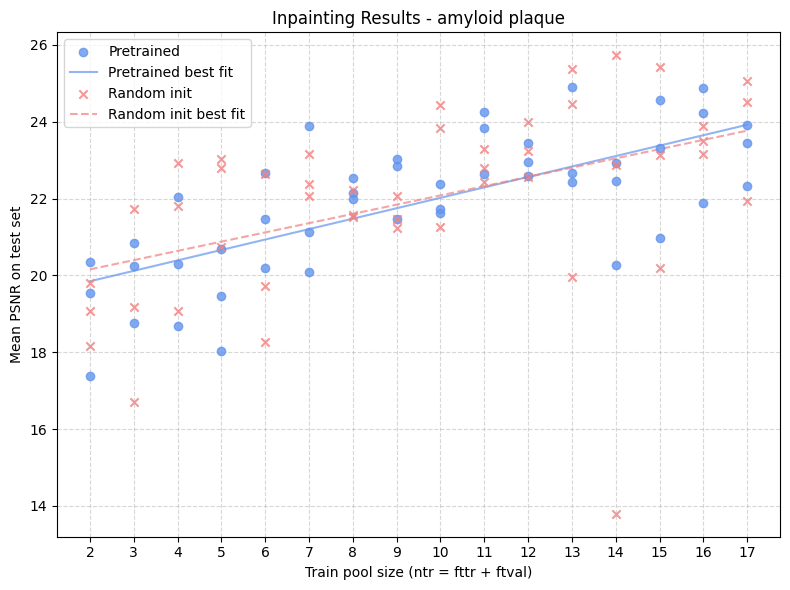

[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.
[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.


/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)
/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)


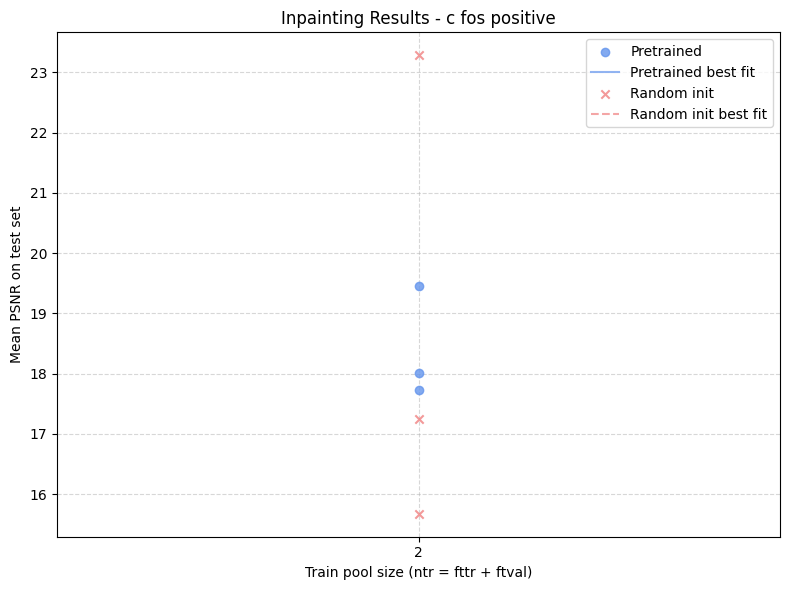

[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.
[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.


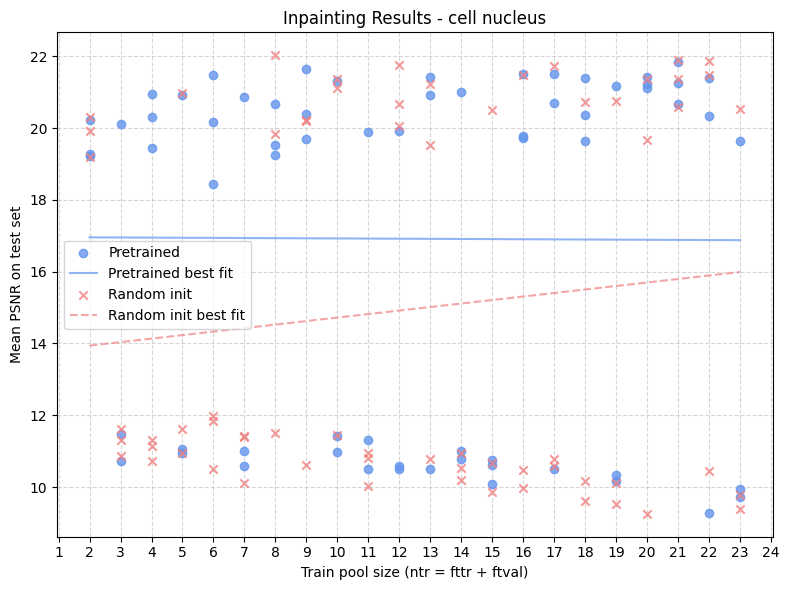

[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.
[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.


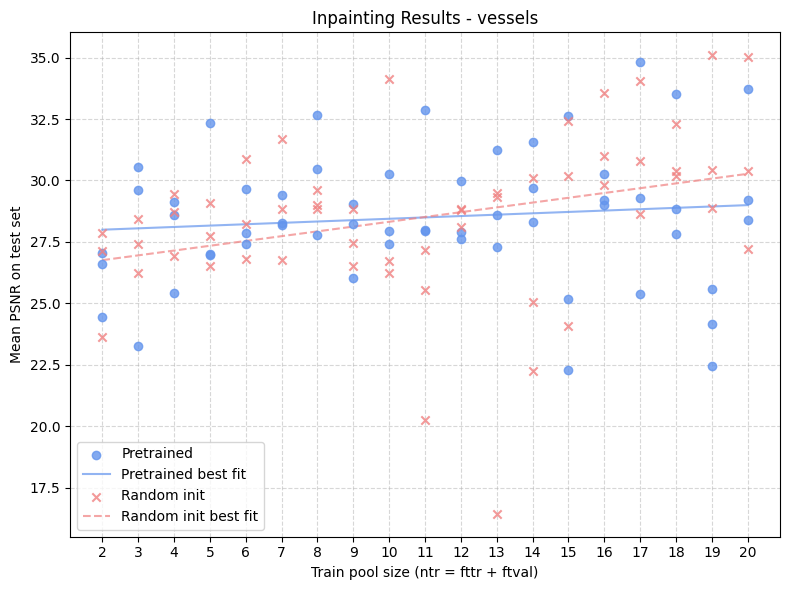

In [11]:
# main entry point
if __name__ == '__main__':

    # define config
    config = InpaintPlotConfig(
        PRETRAIN_ROOT = '/ministorage/adina/selma_inpaint_preds_autumn_sweep_27/preds',
        RANDOM_ROOT = '/ministorage/adina/selma_inpaint_preds_rand_ntc/preds',
        SUBTYPES = ['ALL'],
        EXCLUDE_SUBTYPES = [],
        OUTPUT_DIR = None,
        ASCENDING = True,
        PRETRAIN_FIT_LINE = True,
        RANDOM_FIT_LINE = True
    )

    # run plotting
    run_inpaint_plotting(config)
    

[INFO] Plotting subtypes: ['amyloid_plaque_patches', 'c_fos_positive_patches', 'cell_nucleus_patches', 'vessels_patches']
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.


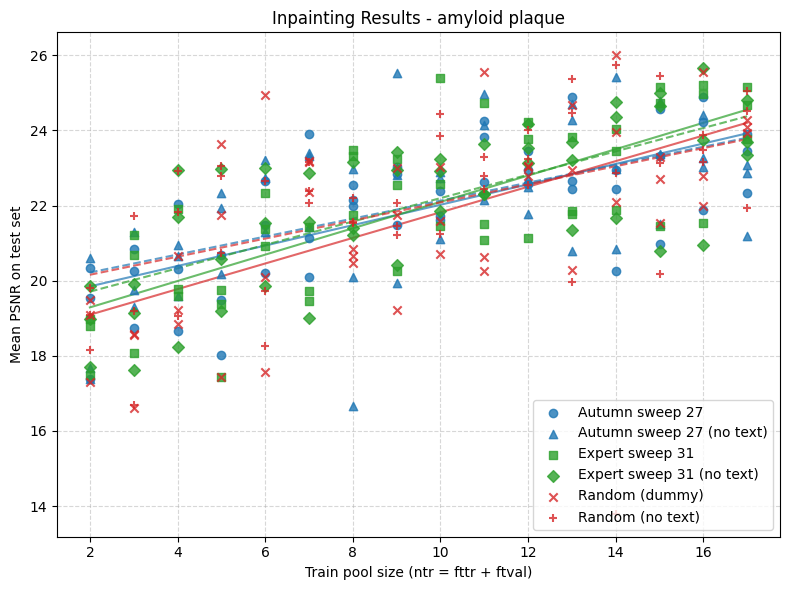

[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.
[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.
[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.
[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.
[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.
[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.


/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)
/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)
/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)
/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)
/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)
/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)


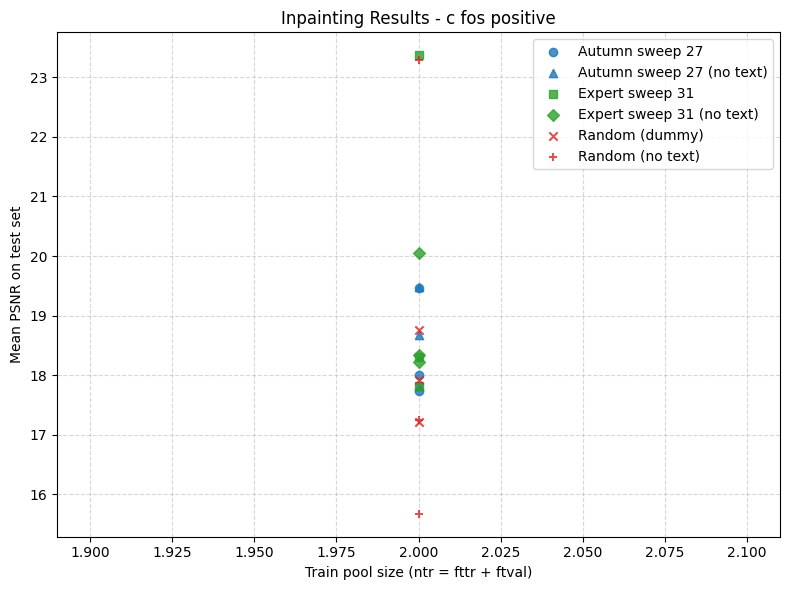

[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.
[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.
[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.
[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.
[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.
[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.


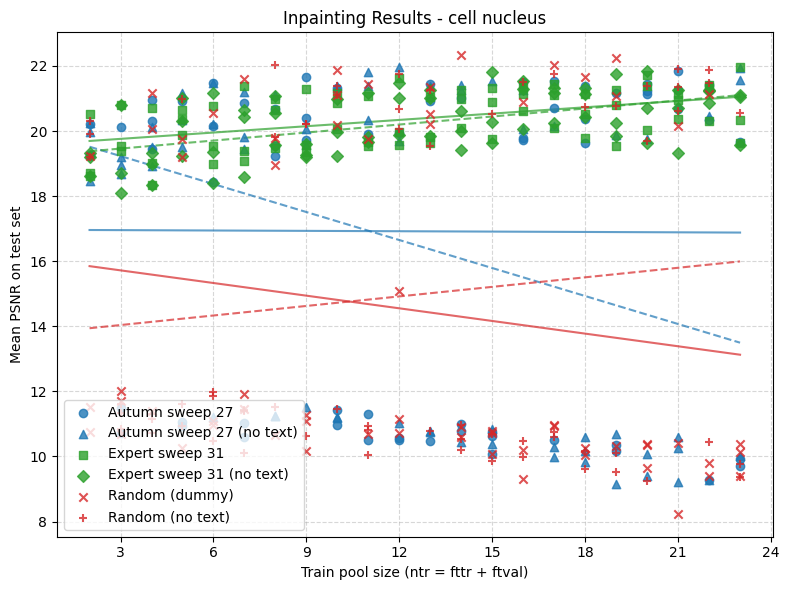

[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.
[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.
[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.
[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.
[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.
[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.


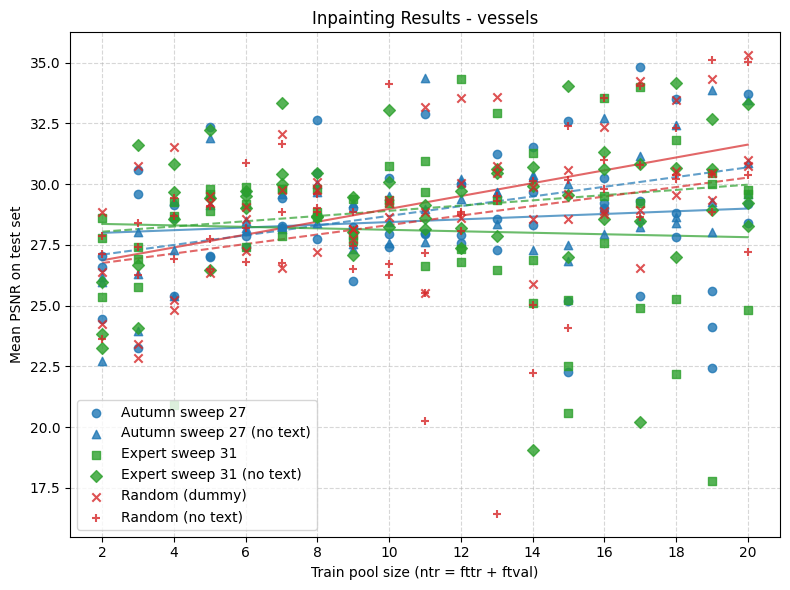

In [12]:
from pathlib import Path

# --- 1. Define all series you want to compare on the same plot ---

# NOTE: I’m assuming each result folder has a "preds" subfolder just like before.
# If not, just remove the "/preds" at the end of each root.
SERIES_CONFIGS = [
    {
        "name": "autumn_27",
        "label": "Autumn sweep 27",
        "root": Path("/ministorage/adina/selma_inpaint_preds_autumn_sweep_27/preds"),
        "color": "tab:blue",
        "marker": "o",
        "linestyle": "-"
    },
    {
        "name": "autumn_27_ntc",
        "label": "Autumn sweep 27 (no text)",
        "root": Path("/ministorage/adina/selma_inpaint_preds_autumn_sweep_27_ntc/preds"),
        "color": "tab:blue",
        "marker": "^",
        "linestyle": "--"
    },
    {
        "name": "expert_31",
        "label": "Expert sweep 31",
        "root": Path("/ministorage/adina/selma_inpaint_preds_expert_sweep_31/preds"),
        "color": "tab:green",
        "marker": "s",
        "linestyle": "-"
    },
    {
        "name": "expert_31_ntc",
        "label": "Expert sweep 31 (no text)",
        "root": Path("/ministorage/adina/selma_inpaint_preds_expert_sweep_31_ntc/preds"),
        "color": "tab:green",
        "marker": "D",
        "linestyle": "--"
    },
    {
        "name": "rand_dummy",
        "label": "Random (dummy)",
        "root": Path("/ministorage/adina/selma_inpaint_preds_rand_dummy/preds"),
        "color": "tab:red",
        "marker": "x",
        "linestyle": "-"
    },
    {
        "name": "rand_ntc",
        "label": "Random (no text)",
        "root": Path("/ministorage/adina/selma_inpaint_preds_rand_ntc/preds"),
        "color": "tab:red",
        "marker": "+",
        "linestyle": "--"
    },
]

ASCENDING = True      # True = left-to-right increasing train pool size
FIT_LINES = True      # draw best-fit lines for each series


# --- 2. Helper to gather points for every series for one subtype ---

def collect_all_series_points_for_subtype(subtype: str, series_configs):
    """
    Returns: dict[name -> list[InpaintPoint]]
    """
    series_points = {}
    for scfg in series_configs:
        pts = _collect_points_for_subtype(subtype, scfg["root"])
        if pts:
            series_points[scfg["name"]] = pts
    return series_points


# --- 3. Multi-series plotting for a single subtype ---

def plot_subtype_inpaint_multi(subtype: str, series_configs, ascending=True, fit_lines=True):
    """
    Plot all configured series on a single PSNR vs train_pool plot for the given subtype.
    """

    series_points = collect_all_series_points_for_subtype(subtype, series_configs)
    if not series_points:
        print(f"[WARN] No points to plot for subtype {subtype} across all series.")
        return

    plt.figure(figsize=(8, 6))
    all_x_vals = []

    for scfg in series_configs:
        name = scfg["name"]
        pts = series_points.get(name, None)
        if not pts:
            # Some runs might be missing a subtype, that's fine.
            print(f"[INFO] No points for series '{name}' and subtype '{subtype}'. Skipping this series.")
            continue

        # group by fold for this series
        by_fold = defaultdict(list)
        for pt in pts:
            by_fold[pt.fold_id].append(pt)

        first_for_series = True
        xs_all = []
        ys_all = []

        for fold_id in sorted(by_fold.keys()):
            fold_pts = sorted(by_fold[fold_id],
                              key=lambda p: p.train_pool,
                              reverse=not ascending)
            xs = [p.train_pool for p in fold_pts]
            ys = [p.mean_psnr for p in fold_pts]
            xs_all.extend(xs)
            ys_all.extend(ys)

            lbl = scfg["label"] if first_for_series else "_nolegend_"
            plt.scatter(
                xs,
                ys,
                label=lbl,
                color=scfg["color"],
                marker=scfg["marker"],
                alpha=0.8,
                zorder=3,
            )
            first_for_series = False

        all_x_vals.extend(xs_all)

        # best-fit line per series
        if fit_lines and len(xs_all) >= 2:
            fit = _calculate_best_fit_line(xs_all, ys_all)
            if fit:
                xfit, yfit = fit
                plt.plot(
                    xfit,
                    yfit,
                    linestyle=scfg["linestyle"],
                    color=scfg["color"],
                    alpha=0.7,
                    zorder=2,
                )

    # x ticks based on all series
    ax = plt.gca()
    if all_x_vals:
        unique_x = sorted(set(all_x_vals))
        ax.set_xticks(unique_x)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    if not ascending:
        ax.invert_xaxis()

    # labels, title, legend, etc.
    pretty_subtype = subtype.replace("_patches", "").replace("_", " ")
    plt.xlabel("Train pool size (ntr = fttr + ftval)")
    plt.ylabel("Mean PSNR on test set")
    plt.title(f"Inpainting Results - {pretty_subtype}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


# --- 4. Run it for all subtypes you care about ---

# Use the first series as the reference to discover subtypes
ref_root = SERIES_CONFIGS[0]["root"]
subtypes = _find_subtypes(ref_root, ["ALL"], exclude=None)
print(f"[INFO] Plotting subtypes: {subtypes}")

for subtype in subtypes:
    plot_subtype_inpaint_multi(
        subtype=subtype,
        series_configs=SERIES_CONFIGS,
        ascending=ASCENDING,
        fit_lines=FIT_LINES,
    )


In [13]:
# --- Helper to gather points for every series for one subtype (unchanged) ---

def collect_all_series_points_for_subtype(subtype: str, series_configs):
    """
    Returns: dict[name -> list[InpaintPoint]]
    """
    series_points = {}
    for scfg in series_configs:
        pts = _collect_points_for_subtype(subtype, scfg["root"])
        if pts:
            series_points[scfg["name"]] = pts
    return series_points


# --- NEW: plot using ALL runs directly (no fold-level aggregation) ---

def plot_subtype_inpaint_all_points(subtype: str, series_configs, ascending=True, fit_lines=True):
    """
    Plot all individual runs (InpaintPoint objects) for each series on one plot.
    No averaging by fold or by train_pool size.
    """

    series_points = collect_all_series_points_for_subtype(subtype, series_configs)
    if not series_points:
        print(f"[WARN] No points to plot for subtype {subtype} across all series.")
        return

    plt.figure(figsize=(8, 6))
    all_x_vals = []

    for scfg in series_configs:
        name = scfg["name"]
        pts = series_points.get(name, None)
        if not pts:
            print(f"[INFO] No points for series '{name}' and subtype '{subtype}'. Skipping.")
            continue

        # sort by train_pool for nicer appearance
        pts_sorted = sorted(pts, key=lambda p: p.train_pool, reverse=not ascending)

        xs = [p.train_pool for p in pts_sorted]
        ys = [p.mean_psnr for p in pts_sorted]
        all_x_vals.extend(xs)

        # scatter ALL points in this series at once
        plt.scatter(
            xs,
            ys,
            label=scfg["label"],  # one label per series
            color=scfg["color"],
            marker=scfg["marker"],
            alpha=0.8,
            zorder=3,
        )

        # best-fit line using ALL points from this series
        if fit_lines and len(xs) >= 2:
            fit = _calculate_best_fit_line(xs, ys)
            if fit:
                xfit, yfit = fit
                plt.plot(
                    xfit,
                    yfit,
                    linestyle=scfg["linestyle"],
                    color=scfg["color"],
                    alpha=0.7,
                    zorder=2,
                )

    # x-axis ticks
    ax = plt.gca()
    if all_x_vals:
        unique_x = sorted(set(all_x_vals))
        ax.set_xticks(unique_x)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    if not ascending:
        ax.invert_xaxis()

    pretty_subtype = subtype.replace("_patches", "").replace("_", " ")
    plt.xlabel("Train pool size (ntr = fttr + ftval)")
    plt.ylabel("Mean PSNR on test set")
    plt.title(f"Inpainting Results - {pretty_subtype}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


[INFO] Plotting subtypes: ['amyloid_plaque_patches', 'c_fos_positive_patches', 'cell_nucleus_patches', 'vessels_patches']
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.
[INFO] amyloid_plaque_patches: scanned 48 tags, found 48 metrics csvs, kept 48 points.


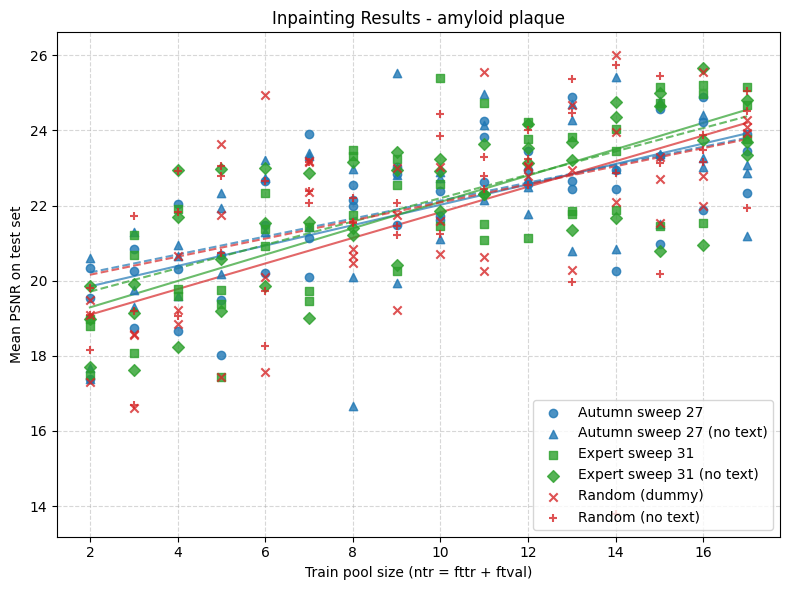

[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.
[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.
[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.
[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.
[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.
[INFO] c_fos_positive_patches: scanned 3 tags, found 3 metrics csvs, kept 3 points.


/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)
/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)
/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)
/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)
/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)
/tmp/ipykernel_3348841/2662103014.py:7: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x_vals, y_vals, deg=1)


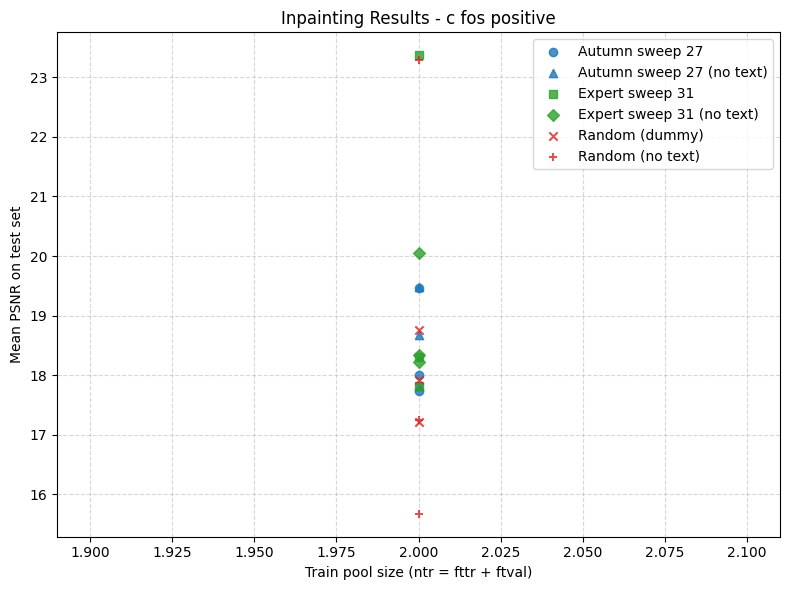

[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.
[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.
[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.
[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.
[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.
[INFO] cell_nucleus_patches: scanned 66 tags, found 66 metrics csvs, kept 66 points.


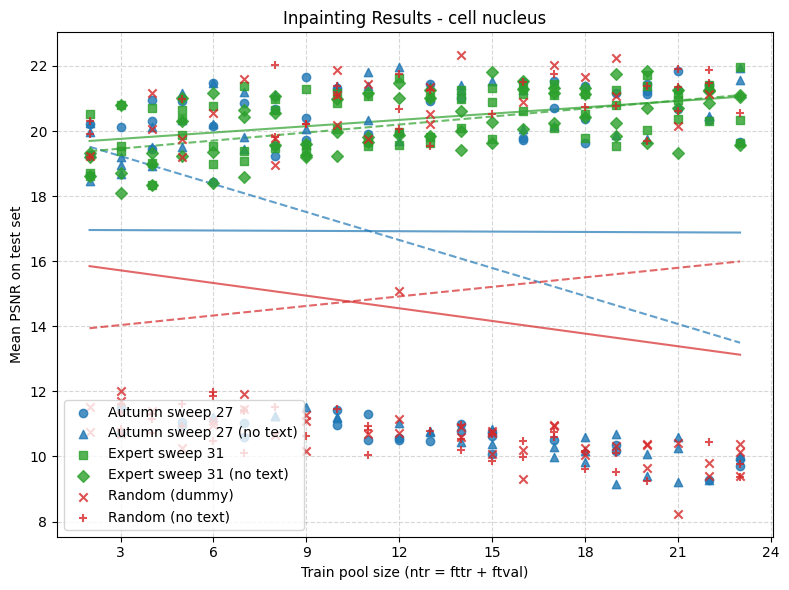

[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.
[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.
[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.
[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.
[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.
[INFO] vessels_patches: scanned 57 tags, found 57 metrics csvs, kept 57 points.


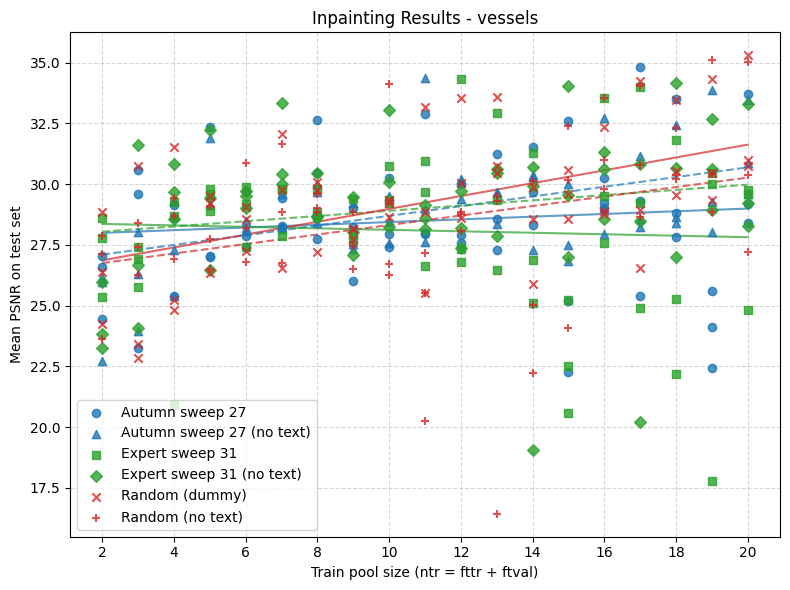

In [14]:
ASCENDING = True
FIT_LINES = True

ref_root = SERIES_CONFIGS[0]["root"]
subtypes = _find_subtypes(ref_root, ["ALL"], exclude=None)
print(f"[INFO] Plotting subtypes: {subtypes}")

for subtype in subtypes:
    plot_subtype_inpaint_all_points(
        subtype=subtype,
        series_configs=SERIES_CONFIGS,
        ascending=ASCENDING,
        fit_lines=FIT_LINES,
    )
